"""
Objective: 
- Extract 10 features: mean, variance, activity start time, left slope, right slope, kurtosis, skewness, area under the curve, full width half maximum (FWHM) and peak amplitude.


Input: Subject, Channel, TimeSamplePoint, HbType

Output: [TemporalFeatures, SpatialFeatures] 
    TemporalFeatures Subject x (Channel x Features)(52*10)

Requirement: 
    index_start: datapoint of Acitvating-Task start
        For example: you have 1250 datapoint with the sampling rate of 10Hz. The task starts at 10s. So you index_start would be 100=10s*10Hz
    index_end: datapoint of Acitvating-Task end

Ref: Zhu, Yibo, et al. "Classifying major depressive disorder using fNIRS during motor rehabilitation." IEEE Transactions on Neural Systems and Rehabilitation Engineering 28.4 (2020): 961-969.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew


def get_activity_start_time(data, index_start):
    gradient = np.gradient(data)
    max_gradient = np.argmax(gradient[0:int(index_start*1.2)])  # 0:index_start*4 # current index_start = 400,
    if max_gradient <= index_start:
        max_gradient = index_start
    return max_gradient


"""
Calulate the left slope based on the data sample time from activity_start_time and  activity_start_time + task_duration//2
"""


def get_left_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start: activity_start+task_duration//2]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
Calulate the right slope based on the data sample time from activity_start_time + task_duration//2 and activity_start_time + task_duration  
"""


def get_right_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start+task_duration//2: activity_start+task_duration]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
For calculating FWHM
"""


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def get_FWHM(y_values, activity_start, task_duration):
    # make sure the peak value is situated in the task duration period
    task = y_values[activity_start:activity_start+task_duration]
    max_task = np.max(task)  # Find the maximum y value
    half_max_y = max_task / 2.0
    max_index_task = np.argmax(task)
    # if max_index_task is in the first two values, set left_index to 0
    if max_index_task <= 1:
        left_index = 0
    else:
        left_index = find_nearest(y_values[:max_index_task], half_max_y)
    # if max_index_task is in the last two values, set right_index to the last value
    if max_index_task >= activity_start+task_duration-1:
        right_index = task_duration-1
    else:
        right_index = find_nearest(
            y_values[max_index_task:], half_max_y) + max_index_task

    return right_index - left_index


"""Get all 10 features"""


def get_10_features(hbo, index_start, task_duration):
    feature_shape = hbo.shape[:2]
    # Feature 1 mean
    mean = np.mean(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 2 variance
    variance = np.std(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 3 activity_start_time
    activity_start_time = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start_time[sub, ch] = get_activity_start_time(
                hbo[sub, ch], index_start=index_start)

    # # Feature 4 left_slope
    left_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            left_slope[sub, ch] = get_left_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)
    # # Feature 5  right_slope
    right_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            right_slope[sub, ch] = get_right_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)

    # # Feature 6 kurtosis
    kurt = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            kurt[sub, ch] = kurtosis(hbo[sub, ch])
    # There might be some nan in kurtosis calucaltion because of all 0-value array
    kurt = np.nan_to_num(kurt)

    # # Feature 7 skewness
    skewness = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            skewness[sub, ch] = skew(hbo[sub, ch])
    # There might be some nan in skewness calucaltion because of all 0-value array
    skewness = np.nan_to_num(skewness)

    # # Feature 8 area under the curve AUC Based on the sample time from activity_start_time + task_duration
    AUC = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            AUC[sub, ch] = np.sum(
                hbo[sub, ch][activity_start:activity_start+task_duration])
    # for sub in range(10):
    #     plt.plot(AUC[sub])

    # # Feature 9 full width half maximum (FWHM)
    # FWHM
    FWHM = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            FWHM[sub, ch] = get_FWHM(
                hbo[sub, ch], activity_start, task_duration)
    # for sub in range(10):
    #     plt.plot(FWHM[sub])

    # # Feature 10 peak
    peak = np.max(hbo, axis=2)

    features = np.concatenate((mean, variance, activity_start_time,
                              left_slope, right_slope, kurt, skewness, AUC, FWHM, peak), axis=1)

    return features

# Data Preparation
## 1. Read the Hemoglobin data 
## 2. Normalize based on all dataset including the HbO and HbR 

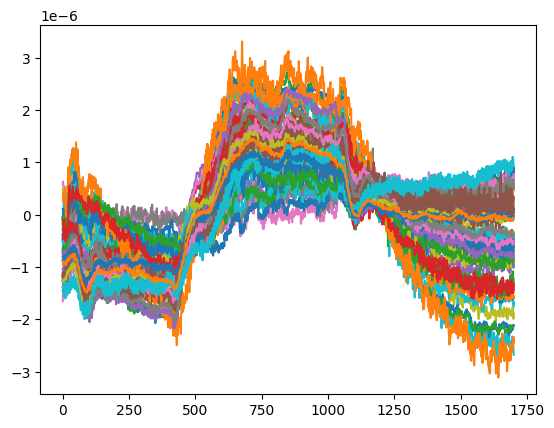

In [6]:
hbo_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/raw_data.npy')

x = np.mean(hbo_data, axis=(0))
for i in range(52):
    plt.plot(x[...,i])

In [3]:
# save_feature_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/duan_rsfc/data'
save_feature_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/zhu_xgboost/raw_cor_ch_data'


model_name = 'zhu_xgboost' # modify me!!!!!!

hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-Lowmid-High/correct_channel_data.npy'
hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-Lowmid-High/correct_channel_data.npy'
feature_save_path = f'/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/HbO-All-Lowmid-High/{model_name}'


def check_create_path(feature_save_path):
    import os
    if not os.path.exists(feature_save_path):
        print('Hello')
        os.makedirs(feature_save_path)
check_create_path(feature_save_path)
# hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/correct_channel_data.npy'
# hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/correct_channel_data.npy'



# hbo_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/correct_channel_data.npy')
hbo_data = np.load(hbo_main_path)
hbo_data = np.transpose(hbo_data, (0,2,1))

# hbr_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/correct_channel_data.npy')
hbr_data = np.load(hbr_main_path)
hbr_data = np.transpose(hbr_data, (0,2,1))
# input = np.random.rand(458, 52, 125)
# please make sure the input data is normalized using something like z-norm
def normalize(data):
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    # Calculate the mean and standard deviation for the current subject
    mean = np.mean(data)
    std = np.std(data)

    # Perform z-normalization for the current subject
    normalized_data= (data - mean) / std
    return normalized_data


input = normalize(np.concatenate((hbo_data[...,np.newaxis],hbr_data[...,np.newaxis]),axis=3))

print(f' input shape -> {input.shape}')
index_start = 10 #400 # 10 
index_end = 70 # 400 + 600 # 70
task_duration = 60 # 600
hbo_type = 0
hbr_type = 1

hbo = input[..., hbo_type]

features = get_10_features(hbo, index_start, task_duration)#(458, 520)

# save data 
np.save(feature_save_path + '/data', features)


 input shape -> (216, 52, 125, 2)


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_47302/2377978253.py:105: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt[sub, ch] = kurtosis(hbo[sub, ch])
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_47302/2377978253.py:113: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness[sub, ch] = skew(hbo[sub, ch])


In [15]:
print(features.shape)

(458, 520)


In [8]:
label = np.load(
    '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/label.npy')

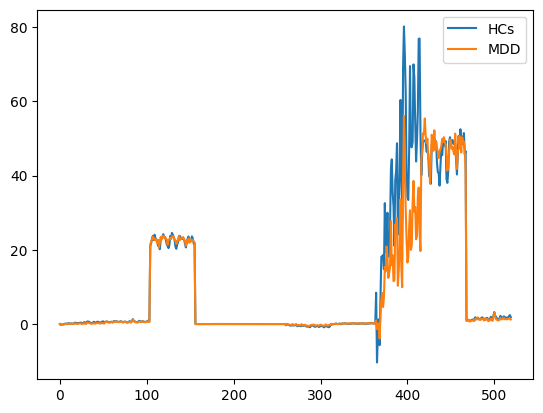

In [15]:
HCs = features[label==0]
MDD = features[label==1]
plt.figure() 

plt.plot(np.mean(HCs, axis=0), label='HCs')
plt.plot(np.mean(MDD, axis=0), label='MDD')

plt.legend()

In [56]:
print(features.shape)

(458, 520)


In [49]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def calculate_FWHM(y_values, activity_start, task_duration):
    task = y_values[activity_start:activity_start+task_duration] # make sure the peak value is situated in the task duration period
    max_task = np.max(task)  # Find the maximum y value
    half_max_y = max_task / 2.0
    max_index_task = np.argmax(task)
    # if max_index_task is in the first two values, set left_index to 0
    if max_index_task<=1:
        left_index=0 
    else:
        left_index = find_nearest(y_values[:max_index_task], half_max_y)
    # if max_index_task is in the last two values, set right_index to the last value
    if max_index_task >= activity_start+task_duration-1:
        right_index = task_duration-1
    else:
        right_index = find_nearest(y_values[max_index_task:], half_max_y) + max_index_task
    print(f'left: {left_index}, right: {right_index}')

    return right_index - left_index


# Example data
y_values = np.array([1, 3, 7, 12, 18, 19, 18, 12, 7, 3, 1])
FWHM = calculate_FWHM(y_values, 0, y_values.shape[0])
print("FWHM:", FWHM)

left: 2, right: 7
FWHM: 5


In [ ]:

# Calulate the left slope based on the data sample time from activity_start_time and  activity_start_time + task_duration//2
def get_left_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start: activity_start+task_duration//2]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


plt.figure(figsize=(12,12))
for ch in range(5):
    data = hbo[0,ch]
    lslope = get_left_slope(data, activity_start_time[0, ch], task_duration)
    rslope = get_right_slope(data, activity_start_time[0, ch], task_duration)

    plt.plot(data, label=f'hbo | left slope={lslope} | right slope={rslope}')
    plt.legend()


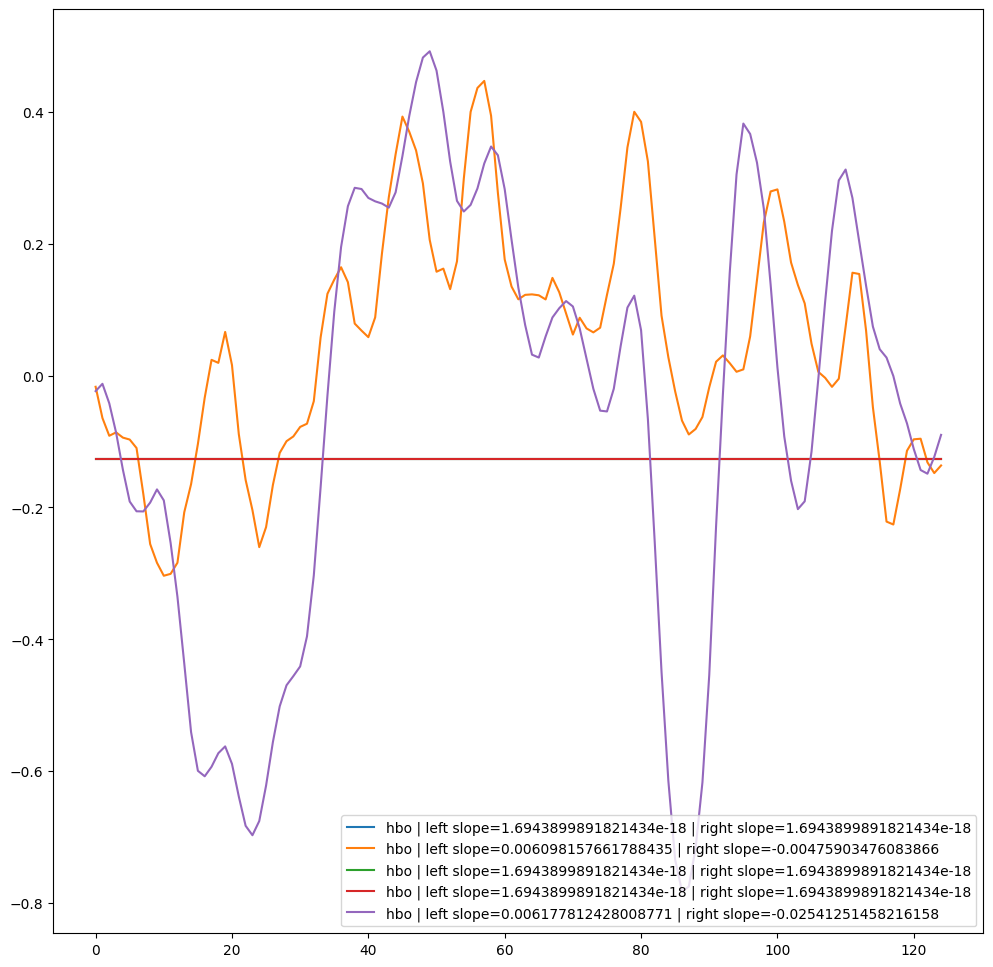

In [24]:

# Calulate the left slope based on the data sample time from activity_start_time and  activity_start_time + task_duration//2
def get_left_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start: activity_start+task_duration//2]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope

# Calulate the right slope based on the data sample time from activity_start_time + task_duration//2 and activity_start_time + task_duration  
def get_right_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start+task_duration//2 : activity_start+task_duration]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope

plt.figure(figsize=(12,12))
for ch in range(5):
    data = hbo[0,ch]
    lslope = get_left_slope(data, activity_start_time[0, ch], task_duration)
    rslope = get_right_slope(data, activity_start_time[0, ch], task_duration)

    plt.plot(data, label=f'hbo | left slope={lslope} | right slope={rslope}')
    plt.legend()


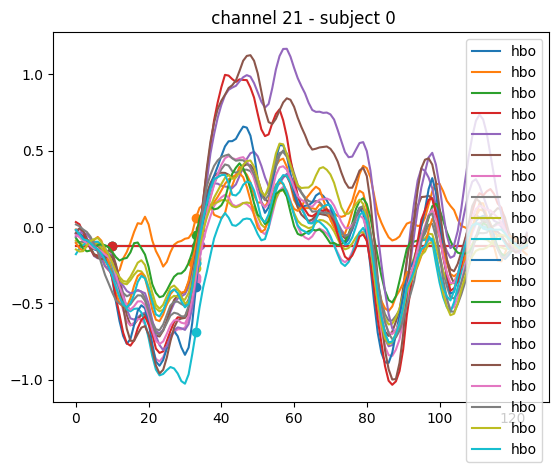

In [14]:
def get_activity_start_time(data, index_start):
    gradient = np.gradient(data)
    max_gradient = np.argmax(gradient[0:index_start*4])
    if max_gradient <= index_start: 
        max_gradient = index_start
    return max_gradient

for ch in range(20):
    data = hbo[0,ch]
    plt.plot(data, label='hbo')
    max_gradient = get_activity_start_time(data, index_start)

    plt.scatter(max_gradient, data[max_gradient])
    plt.title(' channel 21 - subject 0')
    plt.legend()
